# Introduction: Feature Selection¶
In this notebook we will apply feature engineering to the manual engineered features built in two previous notebook. We will reduce the number of features using several methods and then we will test the performance of the features using a fairly basic gradient boosting machine model.

The full set of features was built in Manual Feature Engineering(previous notebook)

We will use three methods for feature selection:

1. Remove collinear features
2. Remove features with greater than a threshold percentage of missing values
3. Keep only the most relevant features using feature importances from a model

Standard imports for data science work. The LightGBM library is used for the gradient boosting machine.


In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# featuretools for automated feature engineering
import featuretools as ft

# matplotlit and seaborn for visualizations
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

# modeling 
import lightgbm as lgb

# utilities
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

# memory management
import gc

In [94]:
#read in data
categoricals = ['CRASH_DATE_EST_I', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
                'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'TRAFFICWAY_TYPE',
                'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'ROADWAY_SURFACE_COND',
                'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I',
                'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'PRIM_CONTRIBUTORY_CAUSE',
                'SEC_CONTRIBUTORY_CAUSE', 'STREET_DIRECTION', 'STREET_NAME', 'PHOTOS_TAKEN_I',
                'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I',
                'MOST_SEVERE_INJURY', 'BEAT_OF_OCCURRENCE','CRASH_HOUR','CRASH_MONTH','CRASH_DAY_OF_WEEK','YEAR']
dtypes = dict.fromkeys(categoricals, 'category')


train = pd.read_csv('../input/00_injury_train_people_vehicle_corrs_removed.csv', dtype = dtypes)
train.info()
train.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207101 entries, 0 to 207100
Columns: 122 entries, RD_NO to vehicle_VEHICLE_TYPE_VAN/MINI-VAN_count
dtypes: category(19), float64(94), int64(3), object(6)
memory usage: 167.0+ MB


(207101, 122)

There are 207,101 rows and 122 features in the dataset.

we are dropping some variables with date and IDs and location information which are not important for modeling.

In [95]:
# save the ids and target
train_labels = train['TARGET']
train_ids = train['RD_NO']

# drop variables
drop_columns =  ['RD_NO','CRASH_DATE', 'DATE_POLICE_NOTIFIED', 'STREET_NAME','STREET_NO','BEAT_OF_OCCURRENCE','LATITUDE','LONGITUDE','LOCATION']
train = train.drop(columns=drop_columns)
train.shape

(207101, 113)

## Remove Collinear Variables

Since we haved added some numrical features from other tables. We are checing collinearity.
Collinear variables can decrease the model's availablility to learn, decrease model interpretability, and decrease generalization performance on the test set. Clearly, these are three things we want to increase, so removing collinear variables is a useful step. We will establish an admittedly arbitrary threshold for removing collinear variables, and then remove one out of any pair of variables that is above that threshold.

In [96]:
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = train.corr().abs()
corr_matrix.head()

,POSTED_SPEED_LIMIT,NUM_UNITS,people_counts,TARGET,people_AGE_count,people_AGE_mean,SEX_F_count,SEX_F_count_norm,SEX_M_count,SEX_M_count_norm,...,vehicle_VEHICLE_TYPE_OTHER VEHICLE WITH TRAILER_count,vehicle_VEHICLE_TYPE_PASSENGER_count,vehicle_VEHICLE_TYPE_PICKUP_count,vehicle_VEHICLE_TYPE_SNOWMOBILE_count,vehicle_VEHICLE_TYPE_SPORT UTILITY VEHICLE (SUV)_count,vehicle_VEHICLE_TYPE_TRACTOR W/ SEMI-TRAILER_count,vehicle_VEHICLE_TYPE_TRACTOR W/O SEMI-TRAILER_count,vehicle_VEHICLE_TYPE_TRUCK - SINGLE UNIT_count,vehicle_VEHICLE_TYPE_UNKNOWN/NA_count,vehicle_VEHICLE_TYPE_VAN/MINI-VAN_count
POSTED_SPEED_LIMIT,1.000000,0.049491,0.118641,0.103594,0.136088,0.039065,0.065305,0.026112,0.115151,0.065009,...,0.002673,0.072215,0.009332,0.001294,0.007552,0.008286,0.003318,0.016044,0.061501,0.009958
NUM_UNITS,0.049491,1.000000,0.213388,0.104067,0.178914,0.033915,0.117653,0.017728,0.139384,0.017419,...,0.000756,0.398321,0.060508,0.000295,0.108460,0.040797,0.006118,0.011399,0.056225,0.075619
people_counts,0.118641,0.213388,1.000000,0.123914,0.732453,0.149559,0.615640,0.182377,0.586406,0.053648,...,0.005240,0.143978,0.003001,0.003878,0.069928,0.031596,0.004289,0.026141,0.187885,0.038532
TARGET,0.103594,0.104067,0.123914,1.000000,0.212941,0.094599,0.081108,0.028287,0.108621,0.056674,...,0.010524,0.073465,0.006498,0.002789,0.012298,0.017096,0.002676,0.033919,0.119476,0.000366
people_AGE_count,0.136088,0.178914,0.732453,0.212941,1.000000,0.172456,0.528030,0.232781,0.532504,0.171365,...,0.008511,0.195517,0.015933,0.003306,0.063535,0.001863,0.007087,0.004612,0.338849,0.034794


In [97]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,POSTED_SPEED_LIMIT,NUM_UNITS,people_counts,TARGET,people_AGE_count,people_AGE_mean,SEX_F_count,SEX_F_count_norm,SEX_M_count,SEX_M_count_norm,...,vehicle_VEHICLE_TYPE_OTHER VEHICLE WITH TRAILER_count,vehicle_VEHICLE_TYPE_PASSENGER_count,vehicle_VEHICLE_TYPE_PICKUP_count,vehicle_VEHICLE_TYPE_SNOWMOBILE_count,vehicle_VEHICLE_TYPE_SPORT UTILITY VEHICLE (SUV)_count,vehicle_VEHICLE_TYPE_TRACTOR W/ SEMI-TRAILER_count,vehicle_VEHICLE_TYPE_TRACTOR W/O SEMI-TRAILER_count,vehicle_VEHICLE_TYPE_TRUCK - SINGLE UNIT_count,vehicle_VEHICLE_TYPE_UNKNOWN/NA_count,vehicle_VEHICLE_TYPE_VAN/MINI-VAN_count
POSTED_SPEED_LIMIT,NaN,0.049491,0.118641,0.103594,0.136088,0.039065,0.065305,0.026112,0.115151,0.065009,...,0.002673,0.072215,0.009332,0.001294,0.007552,0.008286,0.003318,0.016044,0.061501,0.009958
NUM_UNITS,NaN,NaN,0.213388,0.104067,0.178914,0.033915,0.117653,0.017728,0.139384,0.017419,...,0.000756,0.398321,0.060508,0.000295,0.108460,0.040797,0.006118,0.011399,0.056225,0.075619
people_counts,NaN,NaN,NaN,0.123914,0.732453,0.149559,0.615640,0.182377,0.586406,0.053648,...,0.005240,0.143978,0.003001,0.003878,0.069928,0.031596,0.004289,0.026141,0.187885,0.038532
TARGET,NaN,NaN,NaN,NaN,0.212941,0.094599,0.081108,0.028287,0.108621,0.056674,...,0.010524,0.073465,0.006498,0.002789,0.012298,0.017096,0.002676,0.033919,0.119476,0.000366
people_AGE_count,NaN,NaN,NaN,NaN,NaN,0.172456,0.528030,0.232781,0.532504,0.171365,...,0.008511,0.195517,0.015933,0.003306,0.063535,0.001863,0.007087,0.004612,0.338849,0.034794


In [98]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 1 columns to remove.


In [99]:
to_drop

['SAFETY_EQUIPMENT_USAGE UNKNOWN_count_norm']

In [100]:
# Drop Correlated Variables
train = train.drop(columns = to_drop)

print('Training shape: ', train.shape)

Training shape:  (207101, 112)


## Remove Missing Values
There is no right way to choose the threshold for missing values.
In this implementation, if any columns have greater than 70% missing values, they will be removed, which has been done on feature engineering process

In [101]:
# Train missing values (in percent)
train_missing = (train.isnull().sum() / len(train))
train_missing = train_missing.sort_values(ascending = False)
train_missing.head()

LANE_CNT                                           0.338627
people_AGE_mean                                    0.176271
REPORT_TYPE                                        0.022805
SAFETY_EQUIPMENT_CHILD RESTRAINT NOT USED_count    0.015649
SAFETY_EQUIPMENT_NONE PRESENT_count                0.015649
dtype: float64

In [102]:
# Identify missing values above threshold
train_missing = train_missing.index[train_missing > 0.70]
missing = list(set(train_missing))

In [103]:
f'There are {len(missing)} columns with more than 75% missing values'

'There are 0 columns with more than 75% missing values'

Let's drop the columns, one-hot encode the dataframes, and then align the columns of the dataframes.
There are some variables with NaN value. GBM can handle the missing data, so we are going to replace NaN value.



In [105]:
# One Hot Encoding
features = pd.get_dummies(train.drop(columns=missing))

# drop special characters: it will cause issues later

features.columns=features.columns.str.replace(r'[$]', '')
features.columns=features.columns.str.replace(r'[/]', '')
features.columns=features.columns.str.replace(r'[,]', '')
features.columns=features.columns.str.replace(r'[-]', '')

                                               
# Extract features and labels
labels = features['TARGET']
features = features.drop('TARGET', axis = 1)

# List of features for later use
feature_list = list(features.columns)

In [106]:
# Convert to numpy arrays
import numpy as np

# features = np.array(features)
# labels = np.array(labels)

# Training and Testing Sets
from sklearn.model_selection import train_test_split

train, test, train_labels, test_labels = train_test_split(features, labels, 
                                                                            test_size = 0.25, random_state = 2003)

In [107]:
print('Train Features Shape:', train.shape)
print('Train Labels Shape:', train_labels.shape)
print('Test Features Shape:', test.shape)
print('Test Labels Shape:', test_labels.shape)

Train Features Shape: (155325, 362)
Train Labels Shape: (155325,)
Test Features Shape: (51776, 362)
Test Labels Shape: (51776,)


In [109]:
# save to csv
train.to_csv('../input/00_injury_GBM_onehot_corr90_dropped_special.csv')

## Feature Selection through Feature Importances
We can employ for feature selection is to use the feature importances of a model. The relative value of the importances can be used as an approximation of the "relevance" of different features in a model. Moreover, we can use the feature importances to remove features that the model does not consider important.
we can perform our own feature removal by selecting cumulative importance at 95% first. If this leaves too many features, then we can consider removing the features with the lowest importance. 

Since the LightGBM model does not need missing values to be imputed, we can directly fit on the training data. We will use Early Stopping to determine the optimal number of iterations and run the model twice, averaging the feature importances to try and avoid overfitting to a certain set of features.

In [110]:
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(train.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [111]:
# Fit the model twice to avoid overfitting
for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels,
                                                                        test_size = 0.25, random_state = i)
    
    # Train using early stopping
    
    model.fit(train_features, train_y, early_stopping_rounds=100,
              eval_set = [(valid_features, valid_y)],
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += model.feature_importances_

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.91971	valid_0's binary_logloss: 0.352546
Early stopping, best iteration is:
[126]	valid_0's auc: 0.92038	valid_0's binary_logloss: 0.354174
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.920651	valid_0's binary_logloss: 0.351021
Early stopping, best iteration is:
[112]	valid_0's auc: 0.92103	valid_0's binary_logloss: 0.353426


In [112]:
# Make sure to average feature importances! 
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head()

,feature,importance
4,people_AGE_mean,234.5
1,NUM_UNITS,105.0
3,people_AGE_count,101.0
14,AIRBAG_DEPLOYED_DEPLOYED FRONT_count,90.5
139,FIRST_CRASH_TYPE_PEDESTRIAN,88.5


In [113]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 81 features with 0.0 importance


,feature,importance
173,LANE_CNT_17.0,0.0
242,PRIM_CONTRIBUTORY_CAUSE_DISREGARDING YIELD SIGN,0.0
36,vehicle_MANEUVER_DIVERGING_count,0.0
37,vehicle_MANEUVER_DRIVERLESS_count,0.0
181,LANE_CNT_30.0,0.0


We see that one of our features made it into the top 5 most important! That's a good sign for all of our hard work making the features. It also looks like many of the features we made have literally 0 importance. For the gradient boosting machine, features with 0 importance are not used at all to make any splits. Therefore, we can remove these features from the model with no effect on performance (except for faster training)

In [114]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

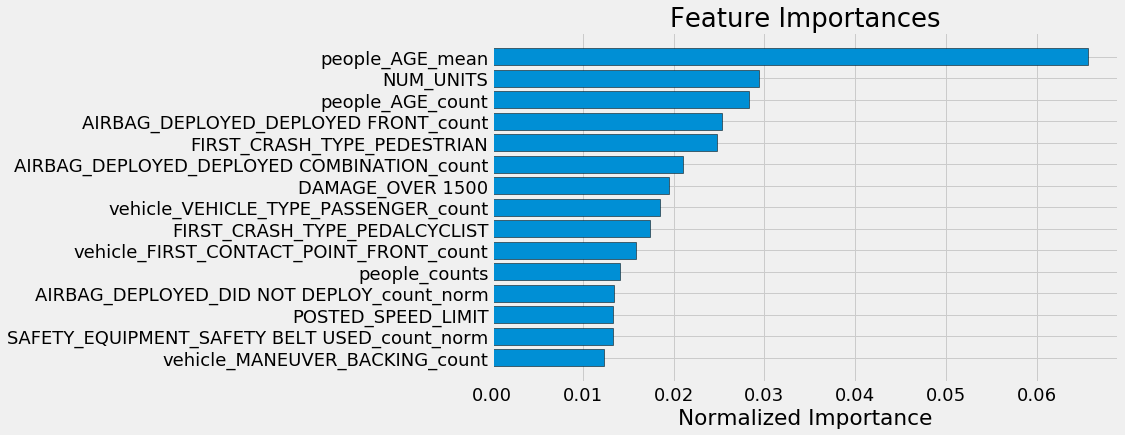

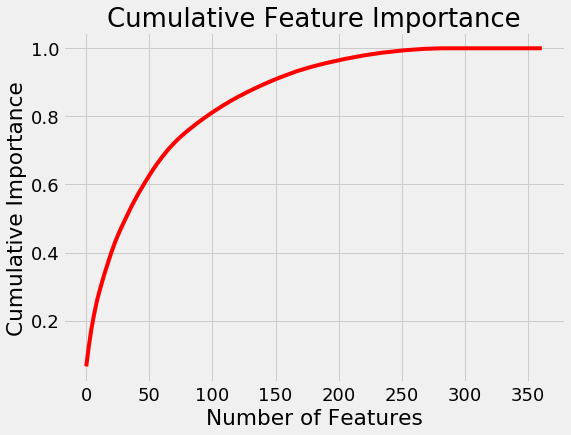

146 features required for 0.90 of cumulative importance


In [116]:
plt.style.use('fivethirtyeight')
norm_feature_importances = plot_feature_importances(feature_importances)

Let's remove the features that have zero importance.



In [117]:
train = train.drop(columns = zero_features)

print('Training shape: ', train.shape)


Training shape:  (155325, 281)


At this point, we can re-run the model to see if it identifies any more features with zero importance. In a way, we are implementing our own form of recursive feature elimination. Since we are repeating work, we should probably put the zero feature importance identification code in a function.

In [118]:
def identify_zero_importance_features(train, train_labels, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the 
    feature importances from a gradient boosting model. 
    
    Parameters
    --------
    train : dataframe
        Training features
        
    train_labels : np.array
        Labels for training data
        
    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """
    
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc', verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

In [119]:
second_round_zero_features, feature_importances = identify_zero_importance_features(train, train_labels)

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.919896	valid_0's binary_logloss: 0.35298
Early stopping, best iteration is:
[126]	valid_0's auc: 0.92038	valid_0's binary_logloss: 0.354174
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.920962	valid_0's binary_logloss: 0.350498
Early stopping, best iteration is:
[126]	valid_0's auc: 0.921241	valid_0's binary_logloss: 0.35273

There are 0 features with 0.0 importance


There are now no 0 importance features left (I guess we should have expected this). If we want to remove more features, we will have to start with features that have a non-zero importance. One way we could do this is by retaining enough features to account for a threshold percentage of importance, such as 95%. At this point, let's keep enough features to account for 95% of the importance. Again, this is an arbitrary decision!

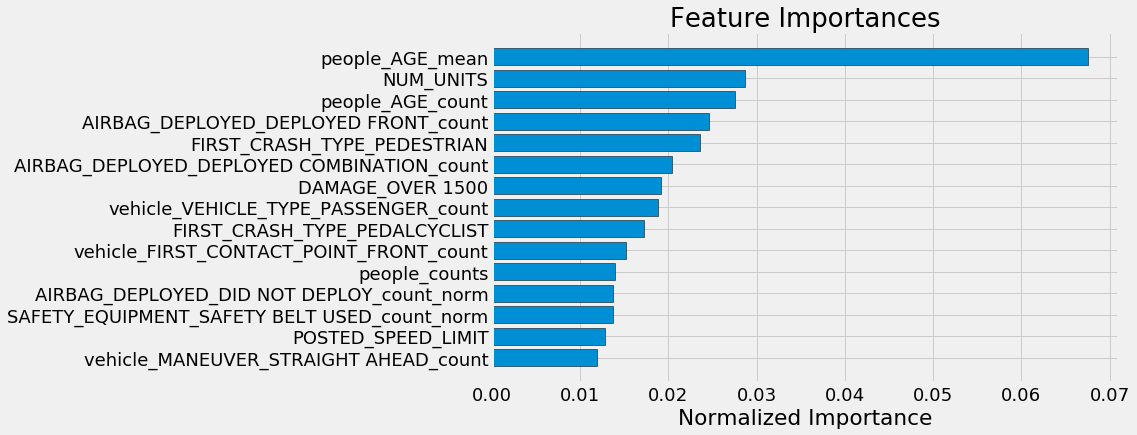

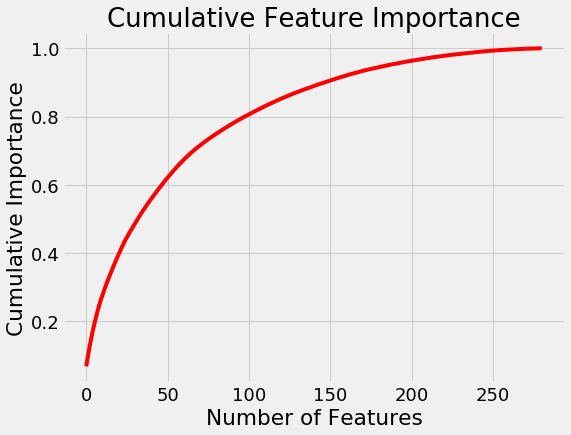

186 features required for 0.95 of cumulative importance


In [120]:
norm_feature_importances = plot_feature_importances(feature_importances, threshold = 0.95)

We can keep only the features needed for 95% importance. This step seems to me to have the greatest chance of harming the model's learning ability, so rather than changing the original dataset, we will make smaller copies. Then, we can test both versions of the data to see if the extra feature removal step is worthwhile.

In [121]:
# Threshold for cumulative importance
threshold = 0.95

# Extract the features to keep
features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])

# Create new datasets with smaller features
train_small = train[features_to_keep]


,people_AGE_mean,NUM_UNITS,people_AGE_count,AIRBAG_DEPLOYED_DEPLOYED FRONT_count,FIRST_CRASH_TYPE_PEDESTRIAN,AIRBAG_DEPLOYED_DEPLOYED COMBINATION_count,DAMAGE_OVER 1500,vehicle_VEHICLE_TYPE_PASSENGER_count,FIRST_CRASH_TYPE_PEDALCYCLIST,vehicle_FIRST_CONTACT_POINT_FRONT_count,...,LIGHTING_CONDITION_DUSK,ROAD_DEFECT_RUT HOLES,SEC_CONTRIBUTORY_CAUSE_PHYSICAL CONDITION OF DRIVER,ROADWAY_SURFACE_COND_ICE,ALIGNMENT_STRAIGHT ON GRADE,CRASH_HOUR_21,SAFETY_EQUIPMENT_SAFETY BELT NOT USED_count,SEC_CONTRIBUTORY_CAUSE_UNDER THE INFLUENCE OF ALCOHOLDRUGS (USE WHEN ARREST IS EFFECTED),ROADWAY_SURFACE_COND_SNOW OR SLUSH,SAFETY_EQUIPMENT_NONE PRESENT_count
45759,55.000000,3.0,2.0,0.0,0,0.0,0,1.0,0,1.0,...,0,0,0,0,0,0,0.0,0,0,0.0
198248,33.500000,2.0,2.0,0.0,0,0.0,1,1.0,0,1.0,...,0,0,0,0,0,0,0.0,0,0,0.0
147940,42.000000,2.0,1.0,0.0,0,0.0,0,1.0,0,1.0,...,0,0,0,0,0,0,0.0,0,0,0.0
155210,47.666667,2.0,3.0,0.0,0,0.0,0,2.0,0,1.0,...,0,0,0,0,0,0,0.0,0,0,0.0
58256,51.500000,2.0,2.0,1.0,0,0.0,1,1.0,0,1.0,...,0,0,0,0,0,0,0.0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163806,36.500000,2.0,2.0,0.0,0,0.0,1,2.0,0,0.0,...,1,0,0,0,0,0,0.0,0,0,0.0
7495,30.000000,2.0,1.0,0.0,0,0.0,1,2.0,0,0.0,...,0,0,0,0,0,0,0.0,0,0,0.0
160282,24.000000,2.0,2.0,0.0,0,0.0,1,2.0,0,1.0,...,0,0,0,0,0,0,0.0,0,0,0.0
164759,21.666667,2.0,3.0,0.0,0,0.0,1,2.0,0,1.0,...,0,0,0,0,0,0,0.0,0,0,0.0


,people_AGE_mean,NUM_UNITS,people_AGE_count,AIRBAG_DEPLOYED_DEPLOYED FRONT_count,FIRST_CRASH_TYPE_PEDESTRIAN,AIRBAG_DEPLOYED_DEPLOYED COMBINATION_count,DAMAGE_OVER 1500,vehicle_VEHICLE_TYPE_PASSENGER_count,FIRST_CRASH_TYPE_PEDALCYCLIST,vehicle_FIRST_CONTACT_POINT_FRONT_count,...,LIGHTING_CONDITION_DUSK,ROAD_DEFECT_RUT HOLES,SEC_CONTRIBUTORY_CAUSE_PHYSICAL CONDITION OF DRIVER,ROADWAY_SURFACE_COND_ICE,ALIGNMENT_STRAIGHT ON GRADE,CRASH_HOUR_21,SAFETY_EQUIPMENT_SAFETY BELT NOT USED_count,SEC_CONTRIBUTORY_CAUSE_UNDER THE INFLUENCE OF ALCOHOLDRUGS (USE WHEN ARREST IS EFFECTED),ROADWAY_SURFACE_COND_SNOW OR SLUSH,SAFETY_EQUIPMENT_NONE PRESENT_count
45759,55.000000,3.0,2.0,0.0,0,0.0,0,1.0,0,1.0,...,0,0,0,0,0,0,0.0,0,0,0.0
198248,33.500000,2.0,2.0,0.0,0,0.0,1,1.0,0,1.0,...,0,0,0,0,0,0,0.0,0,0,0.0
147940,42.000000,2.0,1.0,0.0,0,0.0,0,1.0,0,1.0,...,0,0,0,0,0,0,0.0,0,0,0.0
155210,47.666667,2.0,3.0,0.0,0,0.0,0,2.0,0,1.0,...,0,0,0,0,0,0,0.0,0,0,0.0
58256,51.500000,2.0,2.0,1.0,0,0.0,1,1.0,0,1.0,...,0,0,0,0,0,0,0.0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163806,36.500000,2.0,2.0,0.0,0,0.0,1,2.0,0,0.0,...,1,0,0,0,0,0,0.0,0,0,0.0
7495,30.000000,2.0,1.0,0.0,0,0.0,1,2.0,0,0.0,...,0,0,0,0,0,0,0.0,0,0,0.0
160282,24.000000,2.0,2.0,0.0,0,0.0,1,2.0,0,1.0,...,0,0,0,0,0,0,0.0,0,0,0.0
164759,21.666667,2.0,3.0,0.0,0,0.0,1,2.0,0,1.0,...,0,0,0,0,0,0,0.0,0,0,0.0


## Test New Featuresets
The last step of feature removal we did seems like it may have the potential to hurt the model the most. Therefore we want to test the effect of this removal. To do that, we can use a standard model and change the features.

We will use a fairly standard LightGBM model, similar to the one we used for feature selection. The main difference is this model uses five-fold cross validation for training and we use it to make predictions. There's a lot of code here, but that's because I included documentation and a few extras (such as feature importances) that aren't strictly necessary. For now, understanding the entire model isn't critical, just know that we are using the same model with two different datasets to see which one performs the best.

In [ ]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `RD_NO` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
#     # Extract the ids
#     train_ids = features['RD_NO']
#     test_ids = test_features['RD_NO']
    
#     # Extract the labels for training
#     labels = features['TARGET']
    
#     # Remove the ids and target
#     features = features.drop(columns = ['RD_NO', 'TARGET'])
#     test_features = test_features.drop(columns = ['RD_NO'])
    
    
#     # One Hot Encoding
#     if encoding == 'ohe':
#         features = pd.get_dummies(features)
#         test_features = pd.get_dummies(test_features)
        
#         # Align the dataframes by the columns
#         features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
#         # No categorical indices to record
#         cat_indices = 'auto'
    
#     # Integer label encoding
#     elif encoding == 'le':
        
#         # Create a label encoder
#         label_encoder = LabelEncoder()
        
#         # List for storing categorical indices
#         cat_indices = []
        
#         # Iterate through each column
#         for i, col in enumerate(features):
#             if features[col].dtype == 'object':
#                 # Map the categorical features to integers
#                 features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
#                 test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

#                 # Record the categorical indices
#                 cat_indices.append(i)
    
#     # Catch error if label encoding scheme is not valid
#     else:
#         raise ValueError("Encoding must be either 'ohe' or 'le'")
        
#     print('Training Data Shape: ', features.shape)
#     print('Testing Data Shape: ', test_features.shape)
    
#     # Extract feature names
#     feature_names = list(features.columns)
    
#     # Convert to np arrays
#     features = np.array(features)
#     test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', boosting_type='goss',
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [ ]:
metrics